In [118]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
path = os.getcwd()   
parent = os.path.join(path, os.pardir) 
abspath = os.path.abspath(parent) 
PROJ_ROOT = os.path.join(abspath)
print(PROJ_ROOT)

c:\Users\CHARU\Pictures\ML\MLProjects


In [120]:
# pip install yfinance

In [121]:
import yfinance as yf

tickers = yf.Tickers('Msft')

tickers.tickers['MSFT'].info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'website': 'https://www.microsoft.com',
 'industry': 'Software - Infrastructure',
 'industryKey': 'software-infrastructure',
 'industryDisp': 'Software - Infrastructure',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops and supports software, services, devices and solutions worldwide. The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, and other office services. This segment also provides LinkedIn; and dynamics business solutions, including Dynamics 365, a set of intelligent, cloud-based applications across ERP, CRM, power 

In [122]:
data = yf.download("MSFT", start="2020-01-01")

[*********************100%%**********************]  1 of 1 completed


#### 1. Data Inspection

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048 entries, 2020-01-02 to 2024-03-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1048 non-null   float64
 1   High       1048 non-null   float64
 2   Low        1048 non-null   float64
 3   Close      1048 non-null   float64
 4   Adj Close  1048 non-null   float64
 5   Volume     1048 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 57.3 KB


In [124]:
data.shape

(1048, 6)

In [125]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,154.493820,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570099,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964447,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569809,21634100
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984055,27746500


##### Observations:
1. There doesnt seem to be any preprocessing needed for above data as no Millions, Hundreds, Percentage or other symbols are used.
2. There is not a straightforward column for price which can be used for our time series analysis. Definitions of the present terms:
    1. Open Price: The price of the stock at the beginning of the time period.
    2. High Price: The highest traded price of the stock during the time period.
    3. Low Price: The lowest traded price of the stock during the time period.
    4. Close Price: The price of the stock at the end of the time period.
    From the above, the **Close price** seems to be the most appropriate for time series modelling.
    Thus, proceeding ahead with it.

#### 2. Data Visualization and check for stationarity

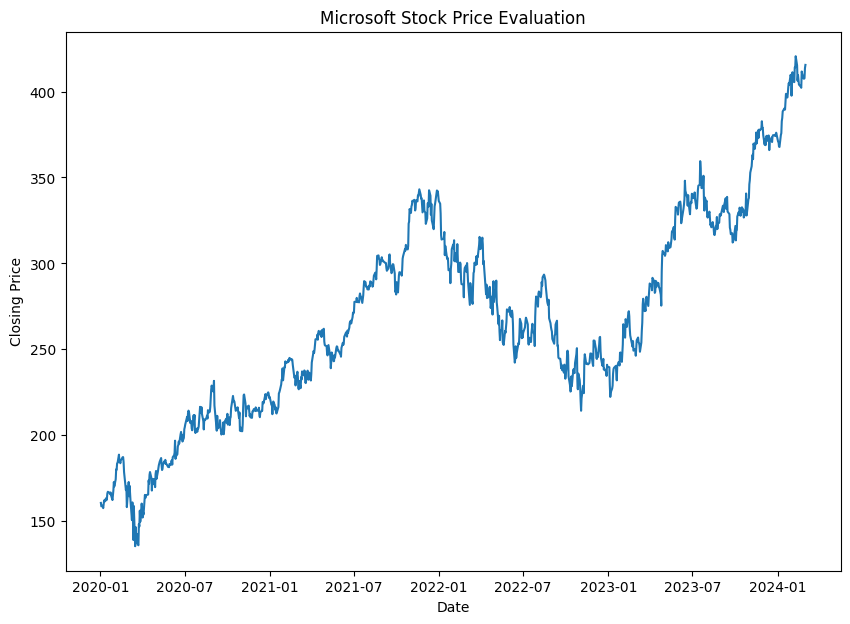

In [126]:
plt.figure(figsize=(10,7))
plt.plot(data['Close'])
plt.title('Microsoft Stock Price Evaluation')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

The series does not seem to have stationarity.

In [127]:
# pip install statsmodels


In [128]:
from statsmodels.tsa.stattools import adfuller

# Checking for stationarity ( Augmented Dickey Fuller test)
def dickey_fuller_test(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Value: {result[4]}')
    if result[1] > 0.05:
        print(f'The time series is not stationary!!! Further action needed!')
    else:
        print(f'The time series is stationary! No further action needed!')

# Applying to our series
dickey_fuller_test(data['Close'])

ADF Statistics: -0.5436312971060293
p-value: 0.8832172815055427
Critical Value: {'1%': -3.4366655541494944, '5%': -2.8643284548748533, '10%': -2.5682546880209087}
The time series is not stationary!!! Further action needed!


As proved from visualization and the Dickey Fuller test , we need to make the series stationary so we will start with differentiating.

In [129]:
# Keeping a copy of original dataframe so that dont need to download again
df = data[['Close']].copy()
df

,Close
Date,
2020-01-02,160.619995
2020-01-03,158.619995
2020-01-06,159.029999
2020-01-07,157.580002
2020-01-08,160.089996
...,...
2024-02-26,407.540009
2024-02-27,407.480011
2024-02-28,407.720001


In [130]:
df['Close_Diff'] = df['Close'].diff()
df


,Close,Close_Diff
Date,,
2020-01-02,160.619995,NaN
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
...,...,...
2024-02-26,407.540009,-2.799988
2024-02-27,407.480011,-0.059998
2024-02-28,407.720001,0.239990


In [131]:
import numpy as np

# dropna not working directly so need following
df = df.dropna(how='any')
df


,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2024-02-26,407.540009,-2.799988
2024-02-27,407.480011,-0.059998
2024-02-28,407.720001,0.239990


In [132]:
# Again check for stationarity
dickey_fuller_test(df['Close_Diff'])

ADF Statistics: -10.471915339628282
p-value: 1.2777935584237346e-18
Critical Value: {'1%': -3.4366655541494944, '5%': -2.8643284548748533, '10%': -2.5682546880209087}
The time series is stationary! No further action needed!


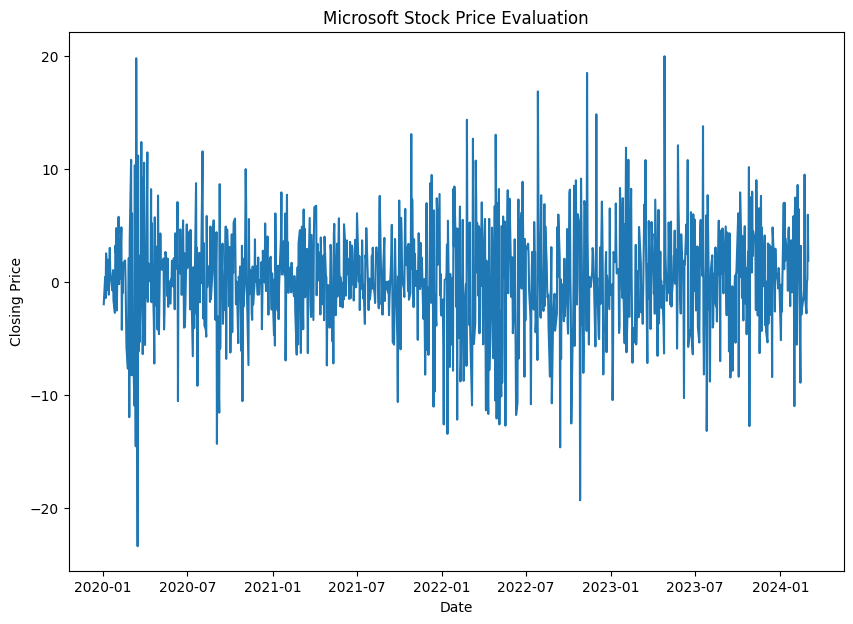

In [133]:
plt.figure(figsize=(10,7))
plt.plot(df['Close_Diff'])
plt.title('Microsoft Stock Price Evaluation')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

Now series is stationary , proceeding ahead. 

#### 3. Splitting data into train and test

In [134]:
# Taking 80 % as training
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [135]:
print(f'Training size = {train.shape[0]} and Testing size = {test.shape[0]}')

Training size = 837 and Testing size = 210


In [136]:
train_index = train.shape[0]
test_index = test.shape[0]

#### 4. Now applying AR Model

To apply the AR model, we need to choose the lag order. For this, we can use ACF and PACF plots. The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are commonly used in time series analysis to determine the appropriate lag order for Autoregressive (AR) models. These plots help you identify the number of lags that have a significant correlation with the current observation.

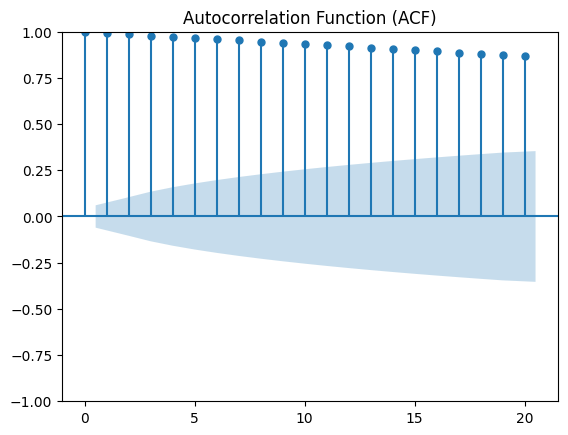

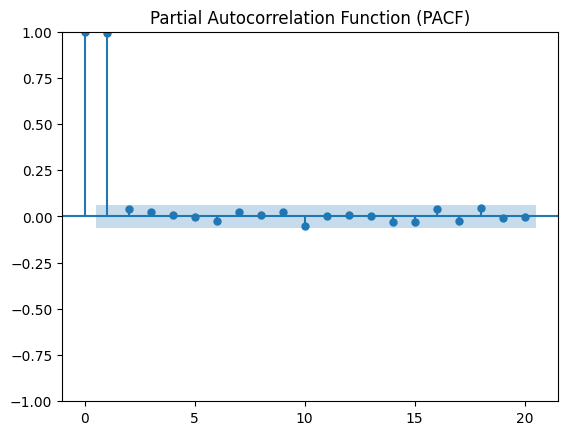

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Close'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data['Close'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

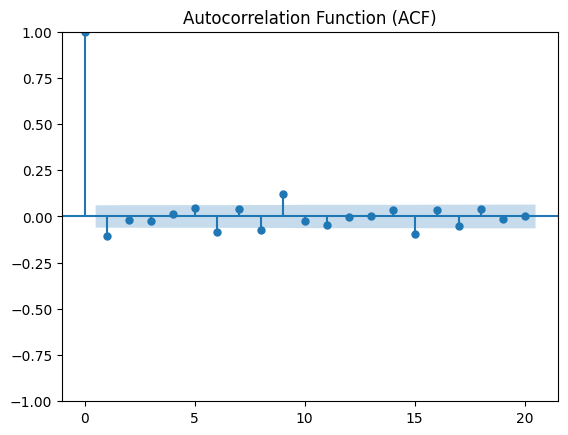

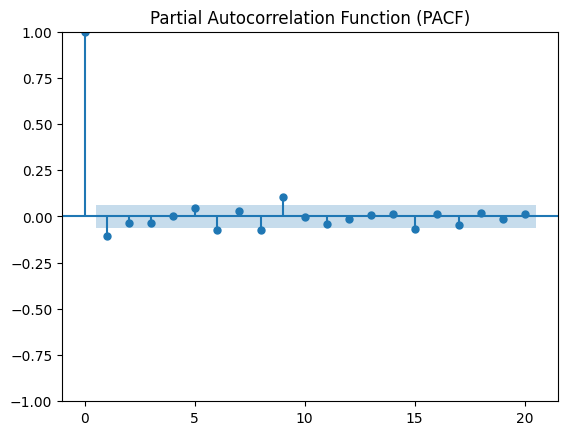

In [138]:
# Plotting the diffs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Close_Diff'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(df['Close_Diff'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

As the ACF and PACF are almost similar, we know that an ARMA(p,q) model will be a better fit for this use case. 
So we will apply a number of AR models to see what would be a good lag value.

And the value of p and q determined from ACF and PACF graphs is 1 and 1.

In [139]:
# Now applying Auto Regression AR model
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.ar_model import AutoReg

# Fit models with different lag orders
for p in range(1, 20):
    model = AutoReg(df['Close'], lags=p)
    model_fit = model.fit()
    print(f'Lag Order {p}: AIC={model_fit.aic}, BIC={model_fit.bic}')

Lag Order 1: AIC=6270.407787764096, BIC=6285.26597369797
Lag Order 2: AIC=6256.260391353391, BIC=6276.067480010987
Lag Order 3: AIC=6252.055340059569, BIC=6276.809413901782
Lag Order 4: AIC=6247.838075549796, BIC=6277.5372142798005
Lag Order 5: AIC=6244.686172771033, BIC=6279.328453327226
Lag Order 6: AIC=6239.319881546182, BIC=6278.903378095101
Lag Order 7: AIC=6230.561973611288, BIC=6275.084757540506
Lag Order 8: AIC=6226.60800660162, BIC=6276.068146512613
Lag Order 9: AIC=6218.50723068274, BIC=6272.902792383724
Lag Order 10: AIC=6203.034801322788, BIC=6262.363847821542
Lag Order 11: AIC=6200.040523596122, BIC=6264.301115092774
Lag Order 12: AIC=6195.5777611741605, BIC=6264.767955053953
Lag Order 13: AIC=6192.394957108387, BIC=6266.512807934412
Lag Order 14: AIC=6189.364229335125, BIC=6268.407788841039
Lag Order 15: AIC=6185.983246838138, BIC=6269.950563920844
Lag Order 16: AIC=6177.872099281433, BIC=6266.761219993738
Lag Order 17: AIC=6174.410301413824, BIC=6268.219268957074
Lag Ord

Taking lag order as 10 as proper AIC and BIC value

In [140]:
final_ar_model = AutoReg(train['Close'], lags=10)
ar_model_fit = final_ar_model.fit()

print(ar_model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  837
Model:                    AutoReg(10)   Log Likelihood               -2473.998
Method:               Conditional MLE   S.D. of innovations              4.819
Date:                Sun, 03 Mar 2024   AIC                           4971.996
Time:                        19:30:19   BIC                           5028.610
Sample:                            10   HQIC                          4993.710
                                  837                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7560      0.939      1.869      0.062      -0.085       3.597
Close.L1       0.9132      0.035     26.425      0.000       0.845       0.981
Close.L2       0.0555      0.047      1.192      0.2

In [141]:
train

,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2023-04-25,275.420013,-6.349976
2023-04-26,295.369995,19.949982
2023-04-27,304.829987,9.459991


In [142]:
test_data = df[['Close', 'Close_Diff']].iloc[train_size+1:]
test_data

,Close,Close_Diff
Date,,
2023-05-03,304.399994,-1.010010
2023-05-04,305.410004,1.010010
2023-05-05,310.649994,5.239990
2023-05-08,308.649994,-2.000000
2023-05-09,307.000000,-1.649994
...,...,...
2024-02-26,407.540009,-2.799988
2024-02-27,407.480011,-0.059998
2024-02-28,407.720001,0.239990


In [143]:
test

,Close,Close_Diff
Date,,
2023-05-02,305.410004,-0.149994
2023-05-03,304.399994,-1.010010
2023-05-04,305.410004,1.010010
2023-05-05,310.649994,5.239990
2023-05-08,308.649994,-2.000000
...,...,...
2024-02-26,407.540009,-2.799988
2024-02-27,407.480011,-0.059998
2024-02-28,407.720001,0.239990


In [144]:
data.Close

Date
2020-01-02    160.619995
2020-01-03    158.619995
2020-01-06    159.029999
2020-01-07    157.580002
2020-01-08    160.089996
                 ...    
2024-02-26    407.540009
2024-02-27    407.480011
2024-02-28    407.720001
2024-02-29    413.640015
2024-03-01    415.500000
Name: Close, Length: 1048, dtype: float64

In [145]:
test_series = test_data.iloc[:, 0]
print(test_series)

Date
2023-05-03    304.399994
2023-05-04    305.410004
2023-05-05    310.649994
2023-05-08    308.649994
2023-05-09    307.000000
                 ...    
2024-02-26    407.540009
2024-02-27    407.480011
2024-02-28    407.720001
2024-02-29    413.640015
2024-03-01    415.500000
Name: Close, Length: 209, dtype: float64


In [146]:
test_diff_series = test_data.iloc[:, 1]
print(test_diff_series)

Date
2023-05-03   -1.010010
2023-05-04    1.010010
2023-05-05    5.239990
2023-05-08   -2.000000
2023-05-09   -1.649994
                ...   
2024-02-26   -2.799988
2024-02-27   -0.059998
2024-02-28    0.239990
2024-02-29    5.920013
2024-03-01    1.859985
Name: Close_Diff, Length: 209, dtype: float64


In [147]:
train_series = train.iloc[:, 0]
print(train_series)

Date
2020-01-03    158.619995
2020-01-06    159.029999
2020-01-07    157.580002
2020-01-08    160.089996
2020-01-09    162.089996
                 ...    
2023-04-25    275.420013
2023-04-26    295.369995
2023-04-27    304.829987
2023-04-28    307.260010
2023-05-01    305.559998
Name: Close, Length: 837, dtype: float64


In [148]:
train_diff_series = train.iloc[:, 1]
print(train_diff_series)

Date
2020-01-03    -2.000000
2020-01-06     0.410004
2020-01-07    -1.449997
2020-01-08     2.509995
2020-01-09     2.000000
                ...    
2023-04-25    -6.349976
2023-04-26    19.949982
2023-04-27     9.459991
2023-04-28     2.430023
2023-05-01    -1.700012
Name: Close_Diff, Length: 837, dtype: float64


In [149]:
# Predict on test set
model = AutoReg(train_diff_series, lags=1)
results = model.fit()

diff_forecast = results.predict(start=train_index, end=train_index + test_index - 1)
diff_forecast

# Reversing the differencing to obtain predictions in original scale
# predictions = df['Close_Diff'].shift(1) + predictions
predictions = diff_forecast + test_series.iloc[-1]
predictions

837     415.862346
838     415.657167
839     415.677580
840     415.675549
841     415.675751
           ...    
1042    415.675733
1043    415.675733
1044    415.675733
1045    415.675733
1046    415.675733
Length: 210, dtype: float64

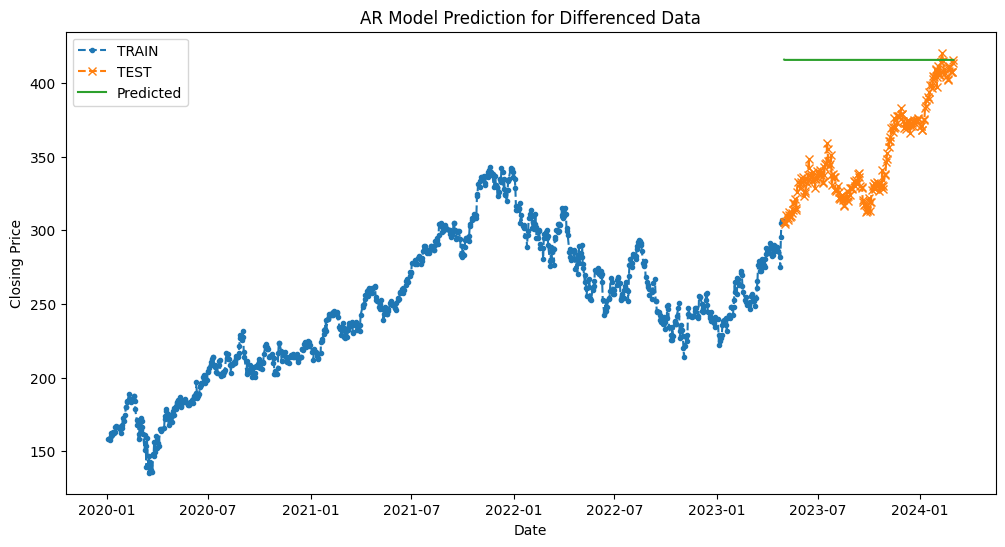

In [150]:
# Plot actual vs. predicted values
ar_predictions_df = pd.DataFrame({'Close': predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=ar_predictions_df, label="Predicted")

plt.title('AR Model Prediction for Differenced Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


**Evaluating above model**

In [151]:
import math
from sklearn.metrics import mean_squared_error

# Calculate the Root Mean Squared Error (RMSE)
# predictions.fillna(0, inplace=True)
mse = mean_squared_error(test['Close'], ar_predictions_df['Close'])
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 5191.00208648521


#### 5. Now proceeding with ARIMA model

For parameters p, d and q, 
1. d is the differencing term which has already been decided as 1 as 1 differencing itself leads to a stationary series.
2. For p and q terms, we saw in earlier ACF and PACF graphs which are almost similar so both values will be equal and
   the order is 1 as only after that, do the lags go out of the significant limit.

In [152]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Close'], order = (1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  837
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2511.212
Date:                Sun, 03 Mar 2024   AIC                           5028.424
Time:                        19:30:20   BIC                           5042.610
Sample:                             0   HQIC                          5033.862
                                - 837                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2873      0.247      1.163      0.245      -0.197       0.772
ma.L1         -0.3845      0.242     -1.586      0.113      -0.860       0.091
sigma2        23.8026      0.921     25.833      0.0

OBS: 
The Prob(Q) value is  0.95, which means the residuals are uncorrelated.
But, the Prob(JB) is 0 meaning the residuals might not have gaussian normal distribution. 
We can check from following plot:

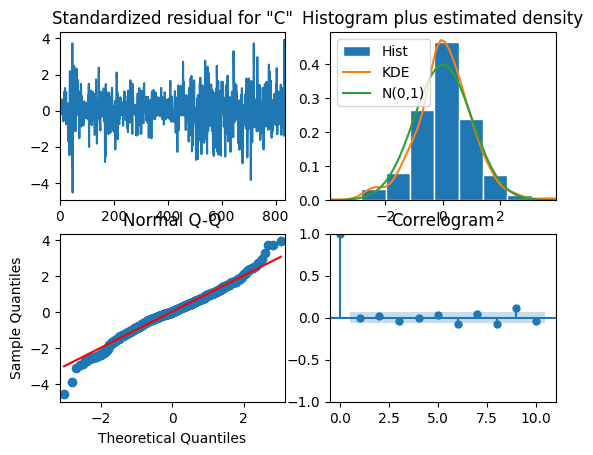

In [153]:
model_fit.plot_diagnostics()
plt.show()

Now as finalized values of p,q and d, we can actually go ahead with our train, test data and do the prediction, forecasting and calculate performance metrics.

In [154]:
# Making model from only training data
arima_model = ARIMA(train['Close_Diff'], order=(1,1,1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_Diff   No. Observations:                  837
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2514.362
Date:                Sun, 03 Mar 2024   AIC                           5034.724
Time:                        19:30:22   BIC                           5048.910
Sample:                             0   HQIC                          5040.162
                                - 837                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0983      0.027     -3.680      0.000      -0.151      -0.046
ma.L1         -1.0000      0.191     -5.243      0.000      -1.374      -0.626
sigma2        23.7859      4.610      5.160      0.0

In [155]:
# Predict on test set
arima_predictions = arima_fit.predict(start=train_index, end=train_index + test_index - 1)

# # Reversing the differencing to obtain predictions in original scale
arima_predictions = test_series.iloc[-1] + arima_predictions
arima_predictions

837     415.857793
838     415.655485
839     415.675374
840     415.673419
841     415.673611
           ...    
1042    415.673594
1043    415.673594
1044    415.673594
1045    415.673594
1046    415.673594
Name: predicted_mean, Length: 210, dtype: float64

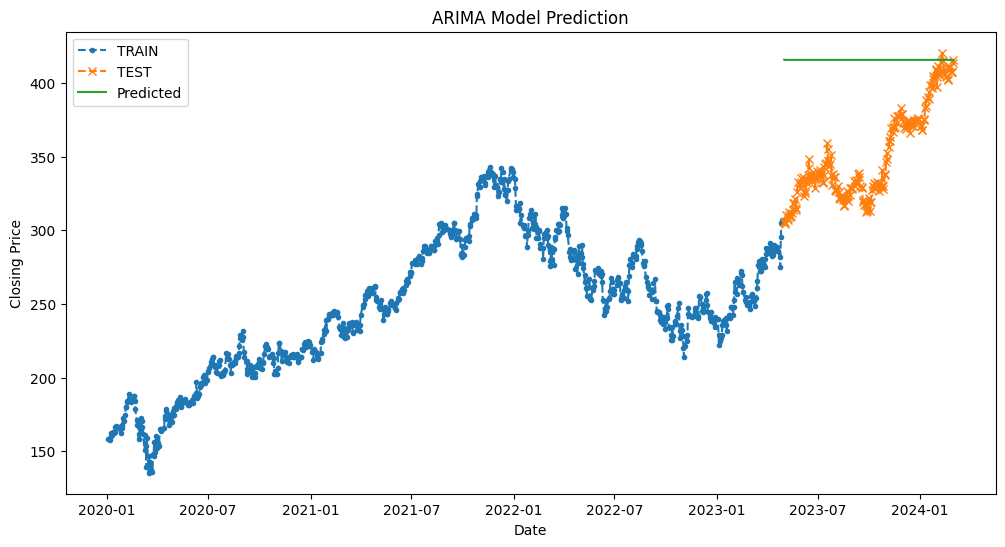

In [156]:
# Plot actual vs. predicted values

arima_predictions = pd.DataFrame({'Close': arima_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=arima_predictions, label="Predicted")

plt.title('ARIMA Model Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [157]:
import math
from sklearn.metrics import mean_squared_error

# Calculate the Root Mean Squared Error (RMSE)
# arima_predictions.fillna(0, inplace=True)
mse = mean_squared_error(test['Close'], arima_predictions['Close'])
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 5190.72219818558


#### 6. SARIMA model

Now we need to check for seasonality. This we will do with the help of **decomposition**. We will break it down into 3:
1. Trend: Overall direction in TS.
2. Seasonality: Predictable and repeated pattern repeating after any amount of time.
3. White Noise: Random components.

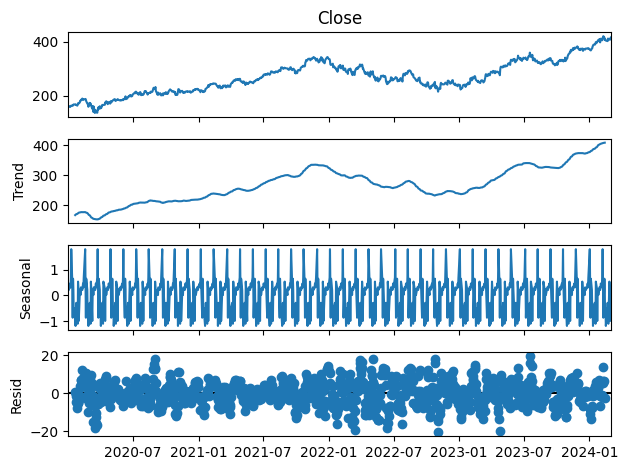

In [158]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(data['Close'], period=25)
decomp_results.plot()
plt.show()

We see that there is overall upward trend. And also see that there is seasonality in data. So can proceed ahead with SARIMA model. 
We will go ahead with differenced data as it is stationary.

In [159]:
!pip install pmdarima

In [160]:
train

,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2023-04-25,275.420013,-6.349976
2023-04-26,295.369995,19.949982
2023-04-27,304.829987,9.459991


In [161]:
from pmdarima import auto_arima

# Use auto_arima to find the best SARIMA model
auto_model = auto_arima(train['Close'], seasonal=True, m=10, trace=True, suppress_warnings=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[10] intercept   : AIC=5034.499, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=5033.915, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=5028.320, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=5028.049, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=5032.990, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[10] intercept   : AIC=5027.395, Time=0.15 sec
 ARIMA(0,1,1)(1,0,0)[10] intercept   : AIC=5028.068, Time=0.65 sec
 ARIMA(0,1,1)(1,0,1)[10] intercept   : AIC=5030.018, Time=1.27 sec
 ARIMA(1,1,1)(0,0,0)[10] intercept   : AIC=5028.959, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[10] intercept   : AIC=5029.270, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[10] intercept   : AIC=5027.611, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[10] intercept   : AIC=5029.798, Time=1.35 sec
 ARIMA(0,1,1)(0,0,0)[10]             : AIC=5026.742, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[10]             : AIC=5027.499, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1

In [162]:
# Now applying the SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train['Close_Diff'], order=(0,1,1), seasonal_order=(0,0,1,10))
sarima_results = sarima.fit()
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Close_Diff   No. Observations:                  837
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 10)   Log Likelihood               -2517.494
Date:                            Sun, 03 Mar 2024   AIC                           5040.987
Time:                                    19:30:46   BIC                           5055.173
Sample:                                         0   HQIC                          5046.426
                                            - 837                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999      0.089    -11.278      0.000      -1.174      -0.826
ma.S.L10      -0.0482      0.030   

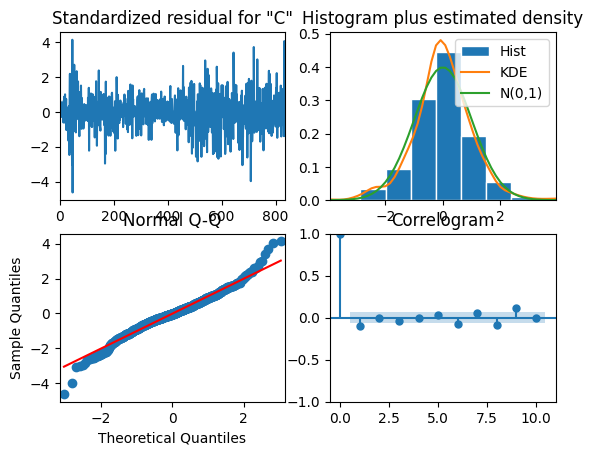

In [163]:
# Now plotting common diagnostics
sarima_results.plot_diagnostics()
plt.show()

In [164]:
# Predict on test set
sarima_predictions = sarima_results.predict(start=train_index, end=train_index + test_index - 1, dynamic=False)

# Reversing the differencing to obtain predictions in original scale
final_predictions = test_series.iloc[-1] + sarima_predictions
final_predictions

837     415.704737
838     415.676857
839     415.800194
840     415.680176
841     415.877719
           ...    
1042    415.672047
1043    415.672047
1044    415.672047
1045    415.672047
1046    415.672047
Name: predicted_mean, Length: 210, dtype: float64

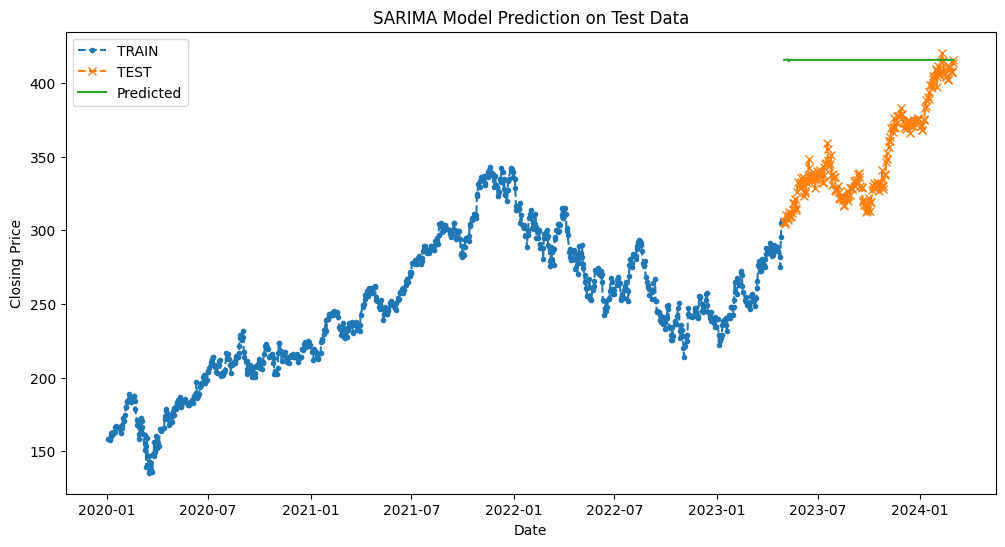

In [165]:
# Plot the actual vs. predicted values on the test set

sarima_predictions = pd.DataFrame({'Close': final_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=sarima_predictions, label="Predicted")

plt.title('SARIMA Model Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [166]:
# Evaluate model performance
mse = mean_squared_error(test['Close'], sarima_predictions['Close'])
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 5189.664726305491


In [167]:
train

,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2023-04-25,275.420013,-6.349976
2023-04-26,295.369995,19.949982
2023-04-27,304.829987,9.459991


#### 6. Exponential Smoothing
1. Single ES

In [168]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exponential_smoothing_model = ExponentialSmoothing(train['Close'], seasonal='add', seasonal_periods=7)
es_model_fit = exponential_smoothing_model.fit()

In [169]:
train_index, test_index

(837, 210)

In [170]:
# Make predictions on the test set
predictions = es_model_fit.predict(start=train_index, end=train_index + test_index - 1)
predictions

837     305.697526
838     304.762371
839     305.781245
840     305.971543
841     305.769108
           ...    
1042    305.781245
1043    305.971543
1044    305.769108
1045    305.463752
1046    305.711813
Length: 210, dtype: float64

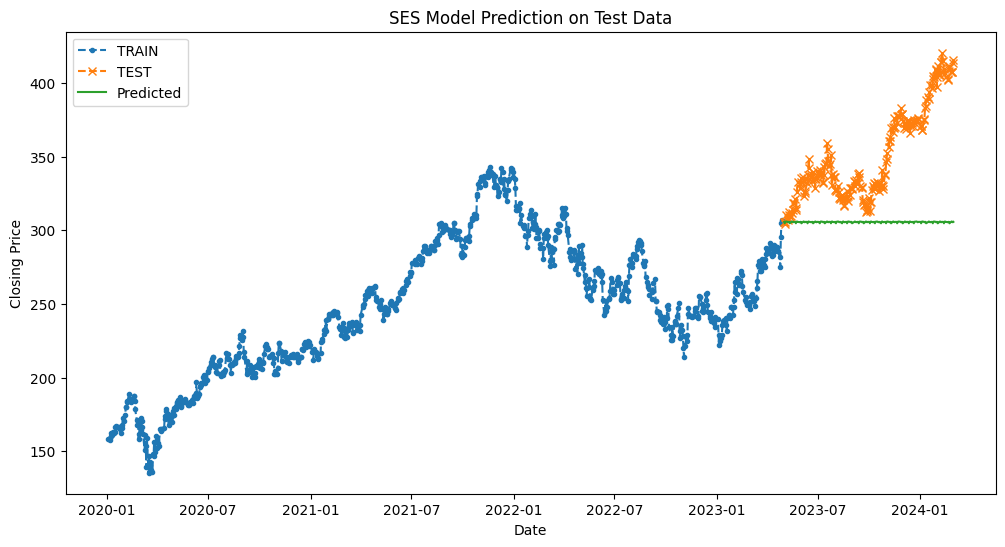

In [171]:
# Plot the actual vs. predicted values on the test set

ses_predictions = pd.DataFrame({'Close': predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=ses_predictions, label="Predicted")

plt.title('SES Model Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


2. Double ES

In [172]:
# Double Exponential Smoothing (Holt's method)
holt_model = ExponentialSmoothing(train['Close'], trend='add', seasonal=None, damped=False)
holt_fit = holt_model.fit()
holt_predictions = holt_fit.predict(start=train_index, end=train_index + test_index - 1)

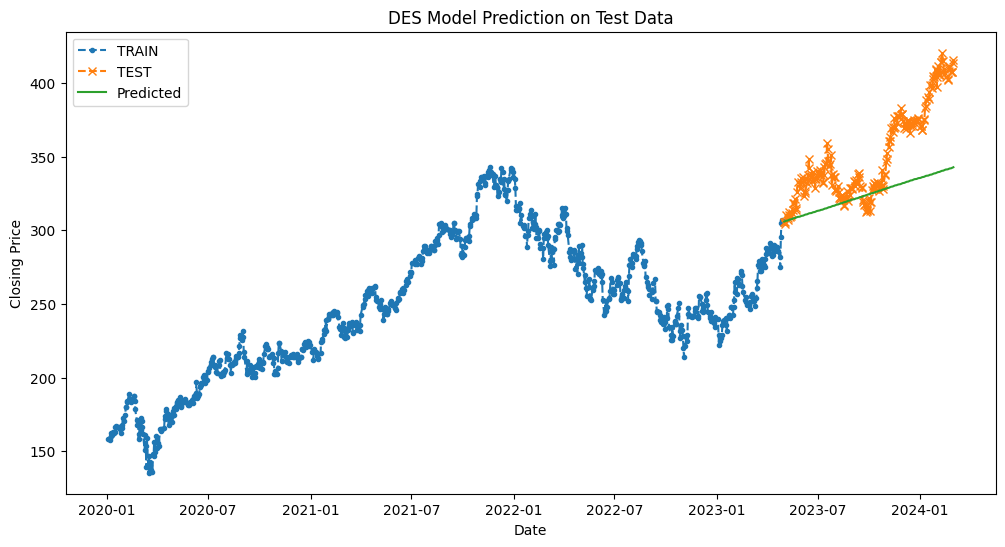

In [173]:
# Plot the actual vs. predicted values on the test set

des_predictions = pd.DataFrame({'Close': holt_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=des_predictions, label="Predicted")

plt.title('DES Model Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


3. Triple ES

In [174]:
# Triple Exponential Smoothing (Holt-Winters' method)
holt_winters_model = ExponentialSmoothing(train['Close'], trend='add', seasonal='add', seasonal_periods=7, damped=False)
holt_winters_fit = holt_winters_model.fit()
holt_winters_predictions = holt_winters_fit.predict(start=train_index, end=train_index + test_index - 1)


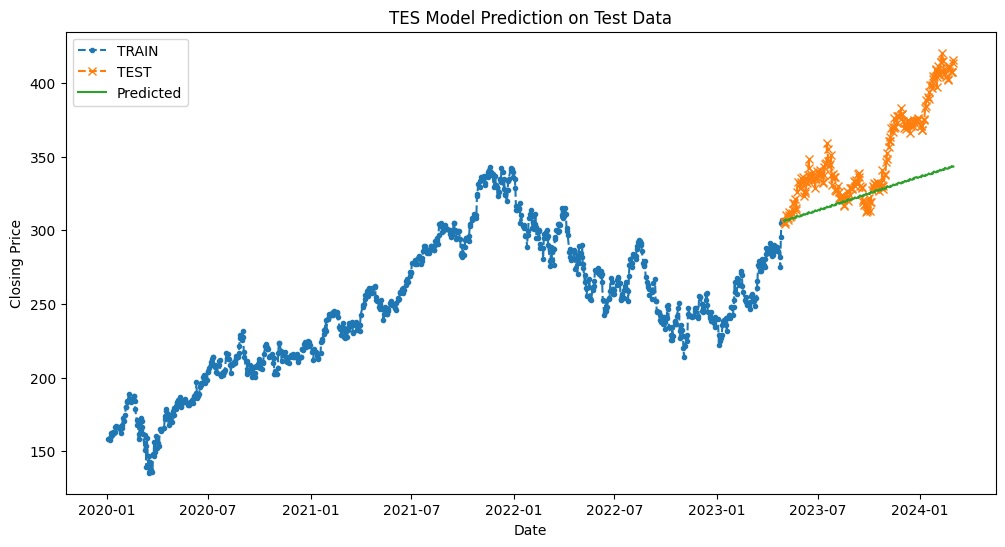

In [175]:
# Plot the actual vs. predicted values on the test set

tes_predictions = pd.DataFrame({'Close': holt_winters_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
plt.plot('Date', 'Close', data=tes_predictions, label="Predicted")

plt.title('TES Model Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [176]:
# Evaluating SES model performance
mse = mean_squared_error(test['Close'], ses_predictions['Close'])
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 3013.93124360027


In [177]:
# Evaluating DES model performance
mse = mean_squared_error(test['Close'], des_predictions['Close'])
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 1215.893348659038


In [178]:
# Evaluating TES model performance
mse = mean_squared_error(test['Close'], tes_predictions['Close'])
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 1183.5903628196158


#### 8. FB Prophet

In [179]:
!pip install pystan

In [180]:
# Make input readable by FB Prophet
# ds: date and y: price/close
train_prophet = pd.DataFrame({'ds': train.index, 'y': train.Close})
test_prophet = pd.DataFrame({'ds': test.index, 'y':test.Close})

In [181]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(train_prophet)

ModuleNotFoundError: No module named 'prophet'

In [ ]:
# Make future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

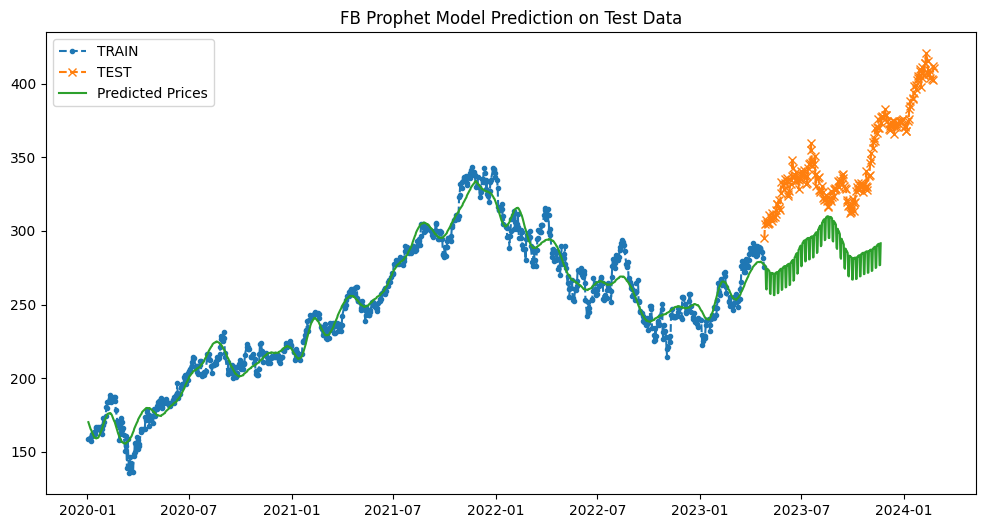

In [ ]:
# Plot the actual vs. predicted values on the test set

# tes_predictions = pd.DataFrame({'Close': holt_winters_predictions, 'Date': test.index})

plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label="TRAIN", marker='.', linestyle='--')
plt.plot(test_prophet['ds'], test_prophet['y'], label="TEST", marker='x', linestyle='--')
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted Prices")

plt.title('FB Prophet Model Prediction on Test Data')
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-03,178.154713,158.413135,180.828919,178.154713,178.154713,-8.020127,-8.020127,-8.020127,4.254044,4.254044,4.254044,-12.274171,-12.274171,-12.274171,0.0,0.0,0.0,170.134587
1,2020-01-06,177.486157,156.373831,178.095952,177.486157,177.486157,-10.733752,-10.733752,-10.733752,4.116677,4.116677,4.116677,-14.850428,-14.850428,-14.850428,0.0,0.0,0.0,166.752406
2,2020-01-07,177.263306,153.532161,176.017660,177.263306,177.263306,-11.836392,-11.836392,-11.836392,3.874226,3.874226,3.874226,-15.710618,-15.710618,-15.710618,0.0,0.0,0.0,165.426914
3,2020-01-08,177.040454,153.808634,175.494564,177.040454,177.040454,-12.139632,-12.139632,-12.139632,4.404569,4.404569,4.404569,-16.544201,-16.544201,-16.544201,0.0,0.0,0.0,164.900821
4,2020-01-09,176.817602,152.289561,175.257093,176.817602,176.817602,-12.988123,-12.988123,-12.988123,4.345975,4.345975,4.345975,-17.334098,-17.334098,-17.334098,0.0,0.0,0.0,163.829479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,2023-11-16,291.835734,245.455117,332.587748,248.286532,332.751451,-0.755383,-0.755383,-0.755383,4.345975,4.345975,4.345975,-5.101358,-5.101358,-5.101358,0.0,0.0,0.0,291.080351
1038,2023-11-17,291.953785,246.854791,335.216528,247.840495,333.199280,-0.737765,-0.737765,-0.737765,4.254044,4.254044,4.254044,-4.991809,-4.991809,-4.991809,0.0,0.0,0.0,291.216020
1039,2023-11-18,292.071836,234.047418,318.176785,247.419370,333.647108,-15.409920,-15.409920,-15.409920,-10.497752,-10.497752,-10.497752,-4.912168,-4.912168,-4.912168,0.0,0.0,0.0,276.661917
1040,2023-11-19,292.189888,230.938258,319.420310,247.012228,334.094937,-15.363192,-15.363192,-15.363192,-10.497739,-10.497739,-10.497739,-4.865453,-4.865453,-4.865453,0.0,0.0,0.0,276.826695


In [ ]:
test_prophet

,ds,y
Date,,
2023-04-26,2023-04-26,295.369995
2023-04-27,2023-04-27,304.829987
2023-04-28,2023-04-28,307.260010
2023-05-01,2023-05-01,305.559998
2023-05-02,2023-05-02,305.410004
...,...,...
2024-02-16,2024-02-16,404.059998
2024-02-20,2024-02-20,402.790009
2024-02-21,2024-02-21,402.179993


In [ ]:
forecast[-len(test_prophet):]['yhat']

833     277.027007
834     276.505882
835     275.929559
836     260.679364
837     260.175120
           ...    
1037    291.080351
1038    291.216020
1039    276.661917
1040    276.826695
1041    291.570730
Name: yhat, Length: 209, dtype: float64

In [ ]:
# Performance metric evaluation
mse = mean_squared_error(test_prophet['y'], forecast[-len(test_prophet):]['yhat'])
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 5261.565439143334


In [ ]:
test_final = prophet_model.predict(test_prophet)


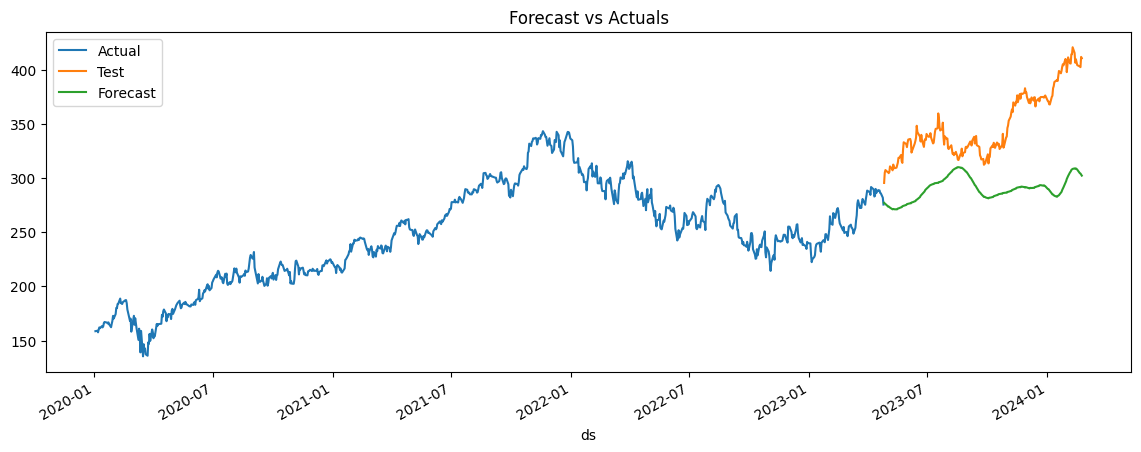

In [ ]:
#plot results
f, ax = plt.subplots(figsize=(14,5))
train_prophet.plot(kind='line',x='ds', y='y', label='Actual', ax=ax)
test_prophet.plot(kind='line',x='ds',y='y',label='Test', ax=ax)
test_final.plot(kind='line',x='ds',y='yhat',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [ ]:
# Performance metric evaluation
mse = mean_squared_error(test_prophet['y'], test_final[-len(test_prophet):]['yhat'])
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 4188.333036245282


In [ ]:
pip install prophet --no-binary :all:

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 9. LSTM

LSTMs are sensitive to scale, so we will normalize our inputs

In [ ]:
df

,Close,Close_Diff
Date,,
2020-01-03,158.619995,-2.000000
2020-01-06,159.029999,0.410004
2020-01-07,157.580002,-1.449997
2020-01-08,160.089996,2.509995
2020-01-09,162.089996,2.000000
...,...,...
2024-02-16,404.059998,-2.500000
2024-02-20,402.790009,-1.269989
2024-02-21,402.179993,-0.610016


In [ ]:
df2 = pd.DataFrame({'Close': df['Close']})
df2

,Close
Date,
2020-01-03,158.619995
2020-01-06,159.029999
2020-01-07,157.580002
2020-01-08,160.089996
2020-01-09,162.089996
...,...
2024-02-16,404.059998
2024-02-20,402.790009
2024-02-21,402.179993


In [ ]:
from sklearn.preprocessing import MinMaxScaler

mscaler = MinMaxScaler(feature_range = (0,1))
df_minmax_scaled = mscaler.fit_transform(np.array(df2).reshape(-1,1))
df_minmax_scaled.shape

(1042, 1)

In [ ]:
len(df2)

1042

In [ ]:
train_data= df2[0:train_size]
train_data

,Close
Date,
2020-01-03,158.619995
2020-01-06,159.029999
2020-01-07,157.580002
2020-01-08,160.089996
2020-01-09,162.089996
...,...
2023-04-19,288.450012
2023-04-20,286.109985
2023-04-21,285.760010


In [ ]:
test_data = df2[train_size:len(df2)]
test_data

,Close
Date,
2023-04-26,295.369995
2023-04-27,304.829987
2023-04-28,307.260010
2023-05-01,305.559998
2023-05-02,305.410004
...,...
2024-02-16,404.059998
2024-02-20,402.790009
2024-02-21,402.179993


In [ ]:
# preparing data for LSTM
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
test

,Close,Close_Diff
Date,,
2023-04-26,295.369995,19.949982
2023-04-27,304.829987,9.459991
2023-04-28,307.260010,2.430023
2023-05-01,305.559998,-1.700012
2023-05-02,305.410004,-0.149994
...,...,...
2024-02-16,404.059998,-2.500000
2024-02-20,402.790009,-1.269989
2024-02-21,402.179993,-0.610016


In [ ]:
class Result:
    """Result is an object used to store the LSTM model variation created alongwith the 
       datasets created according to time basis like weekly , monthly and the history 
    """
    def __init__(self, model, dataframe_x, df_y, df_xtest, df_ytest, history):
        self.model = model
        self.dataframe_x = dataframe_x
        self.df_y = df_y
        self.df_xtest = df_xtest
        self.df_ytest = df_ytest
        self.history = history

In [ ]:
!pip3 install tensorflow



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

def create_lstm(train_data, test_data, n_steps) -> Result:
    n_features = 1
    X, y = prepare_data(train_data['Close'], n_steps)
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    X_test, y_test = prepare_data(test_data['Close'], n_steps)
    
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error',  run_eagerly=True)
    # fit model
    history_lstm = model.fit(X, y, epochs=200, validation_data=(X_test, y_test), batch_size=64, verbose=1)

    res = Result(model, X, y, X_test, y_test, history_lstm)
    return res

### Creating <i>Weekly</i> predictions

In [ ]:
# Creating LSTM for weekly data
result_weekly = create_lstm(train_data, test_data, 7) 

Epoch 1/200
13/13 [==============================] - 5s 356ms/step - loss: 21701.7109 - val_loss: 411.5136
Epoch 2/200
13/13 [==============================] - 3s 244ms/step - loss: 1125.3429 - val_loss: 279.0112
Epoch 3/200
13/13 [==============================] - 4s 335ms/step - loss: 146.5130 - val_loss: 96.7488
Epoch 4/200
13/13 [==============================] - 3s 272ms/step - loss: 78.8484 - val_loss: 128.1842
Epoch 5/200
13/13 [==============================] - 4s 301ms/step - loss: 76.7648 - val_loss: 72.1366
Epoch 6/200
13/13 [==============================] - 4s 286ms/step - loss: 69.0723 - val_loss: 62.5235
Epoch 7/200
13/13 [==============================] - 3s 268ms/step - loss: 66.3765 - val_loss: 72.7320
Epoch 8/200
13/13 [==============================] - 3s 242ms/step - loss: 65.0731 - val_loss: 55.2249
Epoch 9/200
13/13 [==============================] - 3s 249ms/step - loss: 64.3253 - val_loss: 59.8145
Epoch 10/200
13/13 [==============================] - 3s 249ms/s

13/13 [==============================] - 7s 599ms/step - loss: 57.7960 - val_loss: 46.3000
Epoch 17/200
13/13 [==============================] - 8s 603ms/step - loss: 56.1561 - val_loss: 45.9677
Epoch 18/200
13/13 [==============================] - 9s 705ms/step - loss: 54.9910 - val_loss: 45.6367
Epoch 19/200
13/13 [==============================] - 7s 534ms/step - loss: 55.8159 - val_loss: 50.2915
Epoch 20/200
13/13 [==============================] - 7s 542ms/step - loss: 57.9633 - val_loss: 60.1205
Epoch 21/200
13/13 [==============================] - 7s 524ms/step - loss: 56.8998 - val_loss: 44.8426
Epoch 22/200
13/13 [==============================] - 7s 540ms/step - loss: 48.8692 - val_loss: 45.0240
Epoch 23/200
13/13 [==============================] - 7s 583ms/step - loss: 46.6676 - val_loss: 45.4027
Epoch 24/200
13/13 [==============================] - 8s 609ms/step - loss: 44.5356 - val_loss: 29.2931
Epoch 25/200
13/13 [==============================] - 7s 518ms/step - loss: 3

In [ ]:

def plot_losses(history):
    plt.plot(history.history["loss"], label="training loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.show()

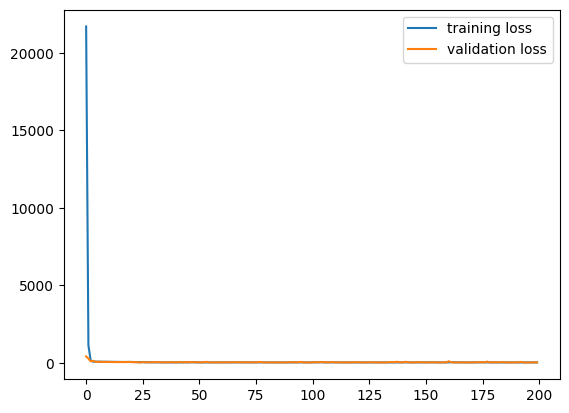

In [ ]:
plot_losses(result_weekly.history)

In [ ]:
def prediction_report(result: Result, n_time, duration_type: str)-> np.array:
    #Lets predict and check performance metrics
    train_predict = result.model.predict(result.dataframe_x)
    test_predict = result.model.predict(result.df_xtest)

    #Calculate RMSE performance metrics
    math.sqrt(mean_squared_error(result.df_y, train_predict))
    #Test Data RMSE
    math.sqrt(mean_squared_error(result.df_ytest, test_predict))

    # Plot actual vs. predicted values
    # Shift train prediction for plotting
    trainPredictPlot = np.empty_like(df2)
    trainPredictPlot[:,:] = np.nan
    trainPredictPlot[n_time:len(train_predict) + n_time, :] = train_predict

    # Shift test prediction for plotting
    testPredictPlot = np.empty_like(df2)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_predict) + (n_time * 2):len(df2), :] = test_predict


    # Plot baseline and predictions

    lstm_predictions = pd.DataFrame({'Close': testPredictPlot.flatten(), 'Date': df2.index})

    plt.figure(figsize=(15, 6))
    plt.plot(train['Close'], label="TRAIN", marker='.', linestyle='--')
    plt.plot(test['Close'], label="TEST", marker='x', linestyle='--')
    plt.plot('Date', 'Close', data=lstm_predictions , label="Predicted")

    plt.title('LSTM Model Prediction on {} Data'.format(duration_type))
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

    return testPredictPlot

2/7 [=======>......................] - ETA: 0s

7/7 [==============================] - 1s 181ms/step


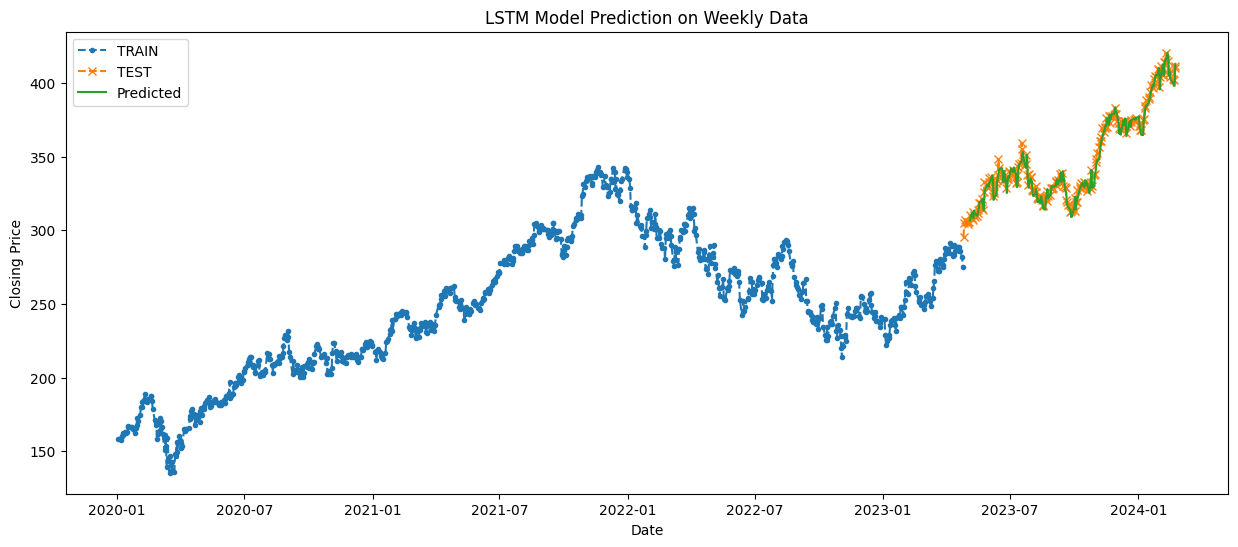

In [ ]:
testPredictPlot = prediction_report(result_weekly, 7, "Weekly")

### Metric used to evaluate system: <u>Bollinger Bands</u>

Bollinger Bands belong among popular stock and cryptocurrency trading indicators. Bollinger Bands consist of 3 lines - price moving average for selected window (typically 20 datapoints), upper and lower Bollinger Band.

Upper and lower Bollinger bands are situated usually 2 standard deviations (sigma) above and below the moving average. Two sigma range means that the price will stay between Upper and Lower Bollinger band around 95% of the time. This can be used as a trading signal, since once price is outside the bands we have statistical outlier that is potentially actionable. Price above Upper Bollinger Band is considered overbought and conversely price below Lower band is considered oversold.

Bollinger Band definition from investopedia: https://www.investopedia.com/terms/b/bollingerbands.asp

In [ ]:
# Calculating Bollinger Bands

In [ ]:
weekly_data = data.iloc[1:]
weekly_data['lstm_weekly'] = testPredictPlot.flatten()
weekly_data


,Open,High,Low,Close,Adj Close,Volume,lstm_weekly
Date,,,,,,,
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570114,21116200,NaN
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964478,20813700,NaN
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569763,21634100,NaN
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984009,27746500,NaN
2020-01-09,161.839996,162.220001,161.029999,162.089996,155.907745,21385000,NaN
...,...,...,...,...,...,...,...
2024-02-16,407.959991,408.290009,403.440002,404.059998,404.059998,22281100,402.470245
2024-02-20,403.239990,404.489990,398.010010,402.790009,402.790009,24307900,399.573975
2024-02-21,400.170013,402.290009,397.220001,402.179993,402.179993,18631100,398.081055


### Goals:


1) Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. 

#### Starting with <u>WEEKLY</u> :

In [ ]:

def plot_bollinger_bands(df: pd.DataFrame, buy_signal: list, sell_signal: list, hold_signal: list, model_name: str):
    fig, ax = plt.subplots(figsize=(16, 5))
    df['predictions'].plot(label='Predicted prices', linewidth=1.5)
    df['BU'].plot(label='Upper BB', linestyle='--', linewidth=1.5)
    df['B_MA'].plot(label='Middle BB', linestyle='--', linewidth=1.5)
    df['BL'].plot(label='Lower BB', linestyle='--', linewidth=1.5)
    
    plt.scatter(df.index, buy_signal, marker='^', color='tab:green', label='Buy', s=100)
    plt.scatter(df.index, np.absolute(sell_signal), marker='v', color='tab:red', label='Sell', s=100)
    plt.scatter(df.index, hold_signal, marker='*', color='tab:blue', label='Hold', s=100)

    plt.title(f'Bollinger Bands Strategy for {model_name} - Trading Signals', fontsize=20)
    plt.legend(loc='upper left')
    plt.show()


In [ ]:
## Bollinger bands with ticks/ indications as to when to buy, hold or sell
def add_signal(data, is_daily, n, m, column):
     # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
     # adds two columns to dataframe with buy, hold and sell signals
    buy_list = []
    sell_list = []
    hold_list = []

    df = pd.DataFrame({"close": data['Close'][1:], "predictions": data[column][1:]})

    # df['predictions']= data[column]
    
    # takes one column from dataframe
    df['B_MA'] = df['predictions'].rolling(n).mean()
    df['B_STD'] = df['predictions'].rolling(n).std() # Rolling Standard deviation for intermediate calculation
    df['BU']  = df['B_MA'] + (df['B_STD'] * 2)
    df['BL']  = df['B_MA'] - (df['B_STD'] * 2)
    df = df.dropna()
    df = df.reset_index(drop = True)

    if is_daily:
        print("inside daily loop")
        for i in df.index:
            if df.loc[i, 'predictions'] > df.loc[i, 'BU']:         
                buy_list.append(np.nan)
                sell_list.append(df.loc[i, 'predictions'])
                hold_list.append(np.nan)

            elif df.loc[i, 'predictions'] < df.loc[i, 'BL']:        
                buy_list.append(df.loc[i, 'predictions'])
                sell_list.append(np.nan)  
                hold_list.append(np.nan)
            else:
                buy_list.append(np.nan)
                sell_list.append(np.nan)
                hold_list.append(df.loc[i, 'predictions'])
    else:
        print("inside non daily loop")         
        for i in df.index:
            if df.loc[i, 'predictions'] > df.loc[i, 'BU']:         
                buy_list.append(np.nan)
                sell_list.append(df.loc[i, 'predictions'])
                hold_list.append(np.nan)

            elif df.loc[i, 'predictions'] < df.loc[i, 'BL']:        
                buy_list.append(df.loc[i, 'predictions'])
                sell_list.append(np.nan)
                hold_list.append(np.nan)
  
            else:
                buy_list.append(np.nan)
                sell_list.append(np.nan)
                hold_list.append(df.loc[i, 'predictions'])

         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
    hold_list = pd.Series(hold_list, name = 'Hold')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
    df = df.join(hold_list)


    plot_bollinger_bands(df, buy_list, sell_list, hold_list, column)
    return df

inside non daily loop


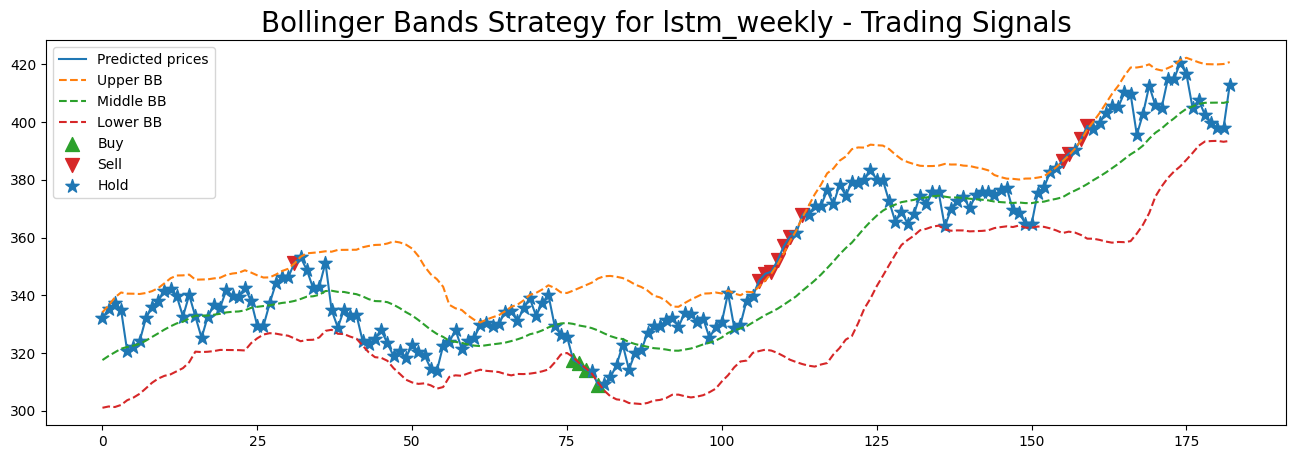

,close,predictions,B_MA,B_STD,BU,BL,Buy,Sell,Hold
0,335.399994,332.146942,317.608315,8.264425,334.137165,301.079464,NaN,NaN,332.146942
1,335.940002,335.416473,319.040898,8.754598,336.550093,301.531703,NaN,NaN,335.416473
2,333.679993,337.351166,320.308852,9.485842,339.280536,301.337167,NaN,NaN,337.351166
3,323.380005,335.096375,321.538354,9.738665,341.015685,302.061024,NaN,NaN,335.096375
4,325.260010,320.613037,322.157352,9.228541,340.614434,303.700269,NaN,NaN,320.613037
...,...,...,...,...,...,...,...,...,...
178,404.059998,402.470245,406.716898,6.698619,420.114135,393.319660,NaN,NaN,402.470245
179,402.790009,399.573975,406.759526,6.647578,420.054681,393.464371,NaN,NaN,399.573975
180,402.179993,398.081055,406.777863,6.621770,420.021403,393.534322,NaN,NaN,398.081055
181,411.649994,398.053680,406.686188,6.733931,420.154049,393.218326,NaN,NaN,398.053680


In [ ]:
weekly_ans = add_signal(weekly_data, False, 20, 2, 'lstm_weekly')
weekly_ans

### Now <u> MONTHLY </u>:

In [ ]:
# Creating LSTM for monthly data
result_monthly = create_lstm(train_data, test_data, 30) 

Epoch 1/200
13/13 [==============================] - ETA: 0s - loss: 14333.9141

13/13 [==============================] - 12s 937ms/step - loss: 14333.9141 - val_loss: 15741.6113
Epoch 2/200
13/13 [==============================] - 19s 1s/step - loss: 6236.4028 - val_loss: 8273.8350
Epoch 3/200
13/13 [==============================] - 18s 1s/step - loss: 4814.9800 - val_loss: 4168.1587
Epoch 4/200
13/13 [==============================] - 19s 1s/step - loss: 1666.0300 - val_loss: 1945.3024
Epoch 5/200
13/13 [==============================] - 18s 1s/step - loss: 1114.9318 - val_loss: 1715.2034
Epoch 6/200
13/13 [==============================] - 18s 1s/step - loss: 1195.5067 - val_loss: 8488.9082
Epoch 7/200
13/13 [==============================] - 19s 1s/step - loss: 50849.6172 - val_loss: 22362.2207
Epoch 8/200
13/13 [==============================] - 19s 1s/step - loss: 18474.2148 - val_loss: 9066.6104
Epoch 9/200
13/13 [==============================] - 18s 1s/step - loss: 2486.5176 - val_loss: 261.7420
Epoch 10/200
13/13 [==============================] - 18s 1s

In [ ]:
result_weekly.df_ytest.shape


(202,)

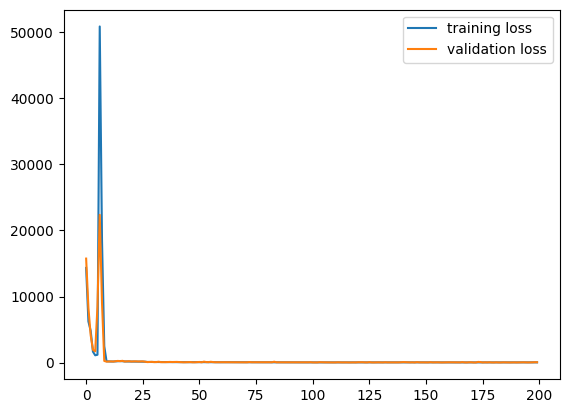

 8/26 [========>.....................] - ETA: 8s

6/6 [==============================] - 4s 630ms/step


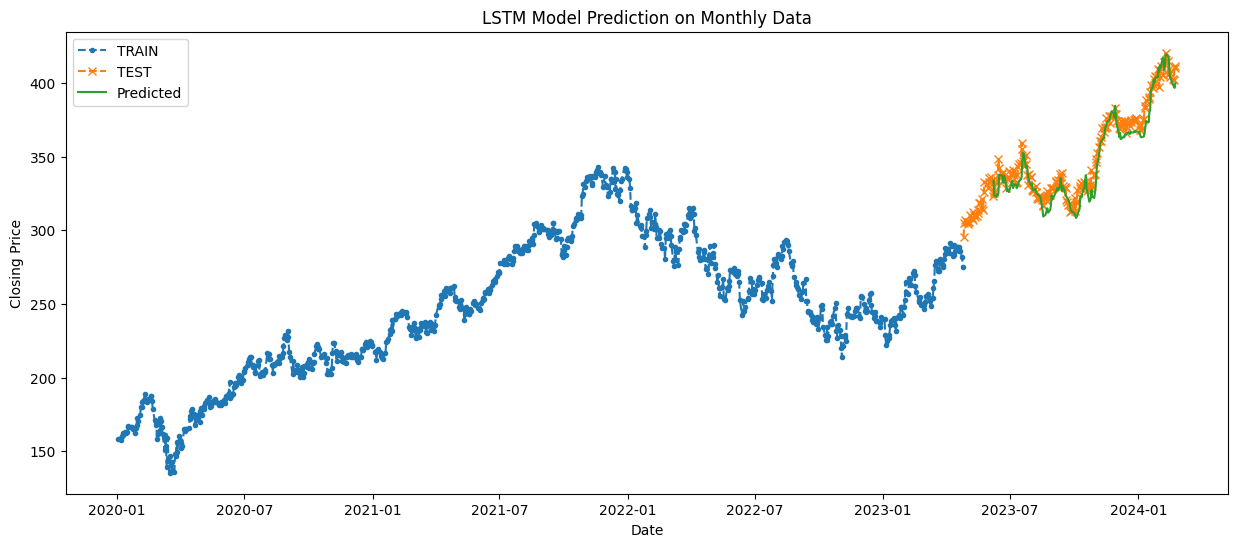

In [ ]:
plot_losses(result_monthly.history)
result_monthly.dataframe_x.shape
testPredictPlot = prediction_report(result_monthly, 30, "Monthly")

In [ ]:
monthly_data = data.iloc[1:]
monthly_data['lstm_monthly'] = testPredictPlot.flatten()
monthly_data


,Open,High,Low,Close,Adj Close,Volume,lstm_monthly
Date,,,,,,,
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570114,21116200,NaN
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964478,20813700,NaN
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569763,21634100,NaN
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984009,27746500,NaN
2020-01-09,161.839996,162.220001,161.029999,162.089996,155.907745,21385000,NaN
...,...,...,...,...,...,...,...
2024-02-16,407.959991,408.290009,403.440002,404.059998,404.059998,22281100,403.406342
2024-02-20,403.239990,404.489990,398.010010,402.790009,402.790009,24307900,398.467804
2024-02-21,400.170013,402.290009,397.220001,402.179993,402.179993,18631100,397.387878


inside non daily loop


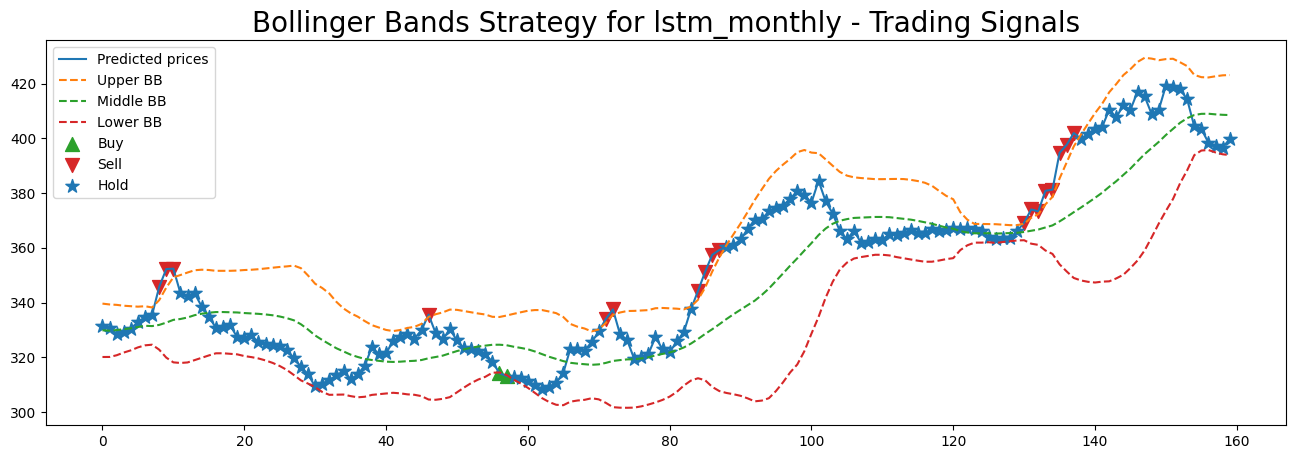

,close,predictions,B_MA,B_STD,BU,BL,Buy,Sell,Hold
0,337.220001,331.399994,329.873759,4.878007,339.629774,320.117745,NaN,NaN,331.399994
1,331.829987,330.805878,329.727242,4.799259,339.325760,320.128723,NaN,NaN,330.805878
2,332.470001,328.575684,329.964238,4.606163,339.176564,320.751912,NaN,NaN,328.575684
3,337.200012,329.356628,330.298509,4.280089,338.858688,321.738331,NaN,NaN,329.356628
4,342.660004,330.530243,330.614874,4.032500,338.679875,322.549873,NaN,NaN,330.530243
...,...,...,...,...,...,...,...,...,...
155,404.059998,403.406342,409.004008,6.703416,422.410841,395.597176,NaN,NaN,403.406342
156,402.790009,398.467804,409.044530,6.633300,422.311130,395.777930,NaN,NaN,398.467804
157,402.179993,397.387878,408.814787,6.962174,422.739136,394.890439,NaN,NaN,397.387878
158,411.649994,396.690399,408.651694,7.214350,423.080394,394.222993,NaN,NaN,396.690399


In [ ]:
monthly_ans = add_signal(monthly_data, False, 20, 2, 'lstm_monthly')
monthly_ans

### Now <u>Daily</u>:

In [ ]:
# Creating LSTM for daily data
result_daily = create_lstm(train_data, test_data, 1) 

Epoch 1/200
13/13 [==============================] - 2s 151ms/step - loss: 62698.7695 - val_loss: 118097.5938
Epoch 2/200
13/13 [==============================] - 2s 144ms/step - loss: 59812.3125 - val_loss: 112028.9609
Epoch 3/200
10/13 [======================>.......] - ETA: 0s - loss: 55529.5117

13/13 [==============================] - 2s 173ms/step - loss: 54822.6406 - val_loss: 97344.4531
Epoch 4/200
13/13 [==============================] - 4s 346ms/step - loss: 41851.6328 - val_loss: 60712.1250
Epoch 5/200
13/13 [==============================] - 4s 312ms/step - loss: 24128.1836 - val_loss: 29696.4707
Epoch 6/200
13/13 [==============================] - 4s 298ms/step - loss: 9669.8115 - val_loss: 6086.0552
Epoch 7/200
13/13 [==============================] - 4s 302ms/step - loss: 724.9415 - val_loss: 1066.2870
Epoch 8/200
13/13 [==============================] - 3s 247ms/step - loss: 255.7048 - val_loss: 21.2422
Epoch 9/200
13/13 [==============================] - 5s 361ms/step - loss: 50.5776 - val_loss: 67.5289
Epoch 10/200
13/13 [==============================] - 4s 297ms/step - loss: 30.3869 - val_loss: 27.8521
Epoch 11/200
13/13 [==============================] - 3s 259ms/step - loss: 27.1946 - val_loss: 22.7570
Epoch 12/200
13/13 [==============================] - 4s 

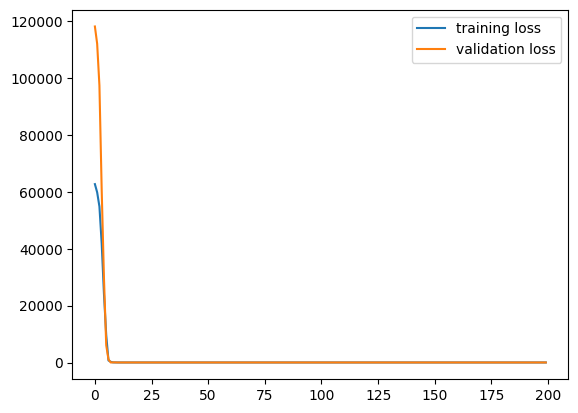

7/7 [==============================] - 2s 89ms/step


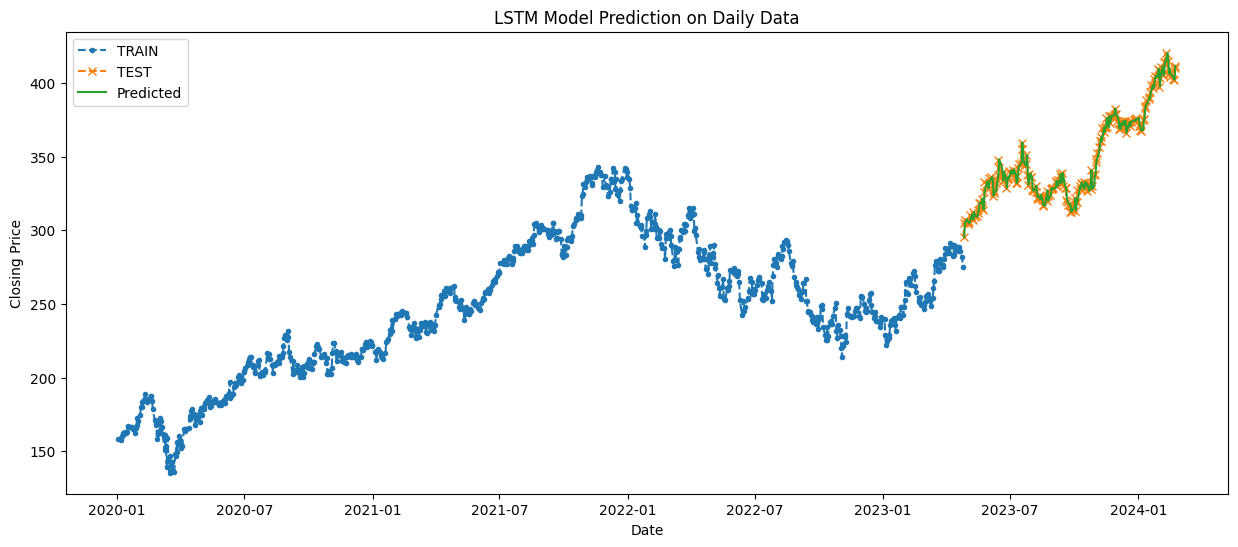

In [ ]:
plot_losses(result_daily.history)
testPredictPlot = prediction_report(result_daily, 1, "Daily")

In [ ]:
daily_data = data.iloc[1:]
daily_data['lstm_daily'] = testPredictPlot.flatten()
daily_data


,Open,High,Low,Close,Adj Close,Volume,lstm_daily
Date,,,,,,,
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570114,21116200,NaN
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964478,20813700,NaN
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569763,21634100,NaN
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984009,27746500,NaN
2020-01-09,161.839996,162.220001,161.029999,162.089996,155.907745,21385000,NaN
...,...,...,...,...,...,...,...
2024-02-16,407.959991,408.290009,403.440002,404.059998,404.059998,22281100,406.640503
2024-02-20,403.239990,404.489990,398.010010,402.790009,402.790009,24307900,404.144897
2024-02-21,400.170013,402.290009,397.220001,402.179993,402.179993,18631100,402.877136


inside daily loop


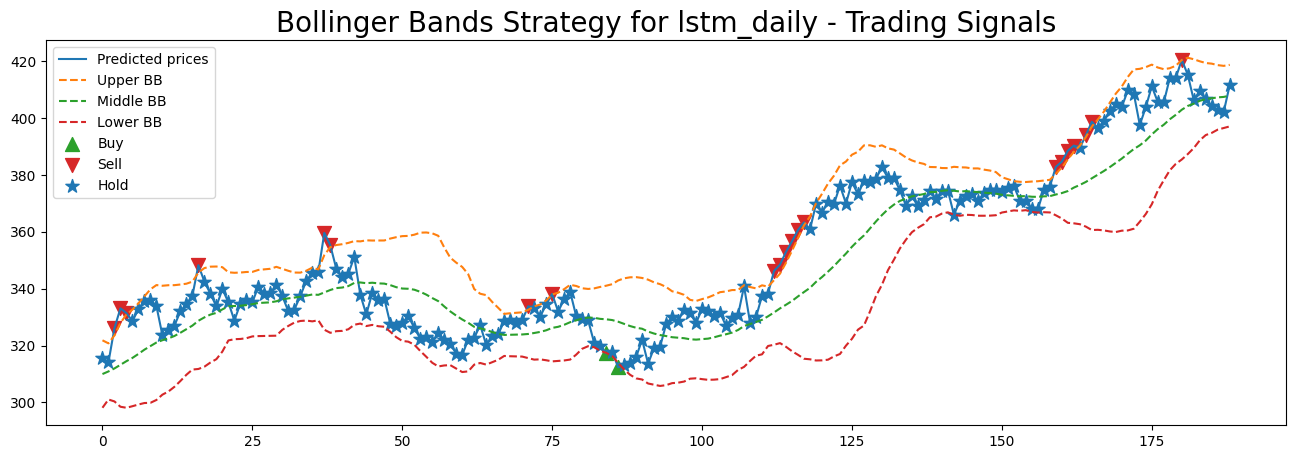

,close,predictions,B_MA,B_STD,BU,BL,Buy,Sell,Hold
0,313.850006,315.500366,309.972658,5.934224,321.841105,298.104210,NaN,NaN,315.500366
1,325.920013,314.093048,310.894800,4.941358,320.777516,301.012084,NaN,NaN,314.093048
2,332.890015,326.140656,311.947302,5.806147,323.559597,300.335008,NaN,326.140656,NaN
3,331.209991,333.098145,313.226418,7.382458,327.991334,298.461501,NaN,333.098145,NaN
4,328.390015,331.421112,314.506514,8.204363,330.915241,298.097787,NaN,331.421112,NaN
...,...,...,...,...,...,...,...,...,...
184,404.059998,406.640503,406.770712,6.341072,419.452856,394.088568,NaN,NaN,406.640503
185,402.790009,404.144897,407.039740,6.092792,419.225324,394.854156,NaN,NaN,404.144897
186,402.179993,402.877136,407.353191,5.674800,418.702791,396.003591,NaN,NaN,402.877136
187,411.649994,402.268188,407.516902,5.464277,418.445457,396.588348,NaN,NaN,402.268188


In [ ]:
daily_ans = add_signal(daily_data, True, 20, 2, 'lstm_daily')
daily_ans

## Goals:

2. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize hold period.

Capital returns are the returns on investment , ie, the calculation of profit made from trading on above signals for various time periods. The <u><i>goal of our project</u></i> is
to provide such trading advice in order to <b>maximize our capital return and minimize losses</b>.
- It can be done on the basis of calculating the difference between the bought value of the stock on buy signal and the sell value of the stock
on the sold signal. 
- And if there are only hold signals, then we can calculate on the basis of what was the starting value when you started holding the stock and 
till now or the last price of stock for which you have continued to hold.

In [ ]:
def money_made(df: pd.DataFrame, duration: str):

    profit_list = []
    index_list = [0]
    
    [index_list.append(idx) for idx in df.index if df.loc[idx, 'Buy'] or df.loc[idx, 'Sell']];
    index_list.append(df.shape[0]-1)


    if df[df['Buy'] == True].shape[0] != 0 or df[df['Sell'] == True].shape[0] != 0:
      
        for j in range(len(index_list)):
            if j == len(index_list) - 1: break
            if j == len(index_list) - 2:
                start = index_list[j+1]
                end = index_list[-1]
            else:
                start = index_list[j]
                end = index_list[j+1]
                if j == len(index_list) - 2: break
                
            difference = df.loc[end, 'close'] - df.loc[start, 'close'] # last value - first value
            percent = np.round((difference/df.loc[start, 'close']) * 100, 2)
            profit_list.append(percent)
        
    # If only hold signal exists
    else:
        difference = df.loc[df.shape[0]-1, 'close'] - df.loc[0, 'close'] # last value - first value
        percent = np.round((difference/df.loc[0, 'close']) * 100, 2)
        profit_list.append(percent)
        
    print(f'The recommendations from the LSTM model on {duration} basis helped us in making the following percentage of money: {profit_list}')
    
    return profit_list

#### Capital Return for <u> daily basis </u>

In [ ]:
# Calculating the capital return on the money made based on trading on daily basis

daily_return = money_made(daily_ans, "Daily") 

The recommendations from the LSTM model on Daily basis helped us in making the following percentage of money: [30.74]


#### Capital Return for <u> weekly basis </u>

In [ ]:
# Calculating the capital return on the money made based on trading on weekly basis

weekly_return = money_made(weekly_ans, "Weekly") 

The recommendations from the LSTM model on Weekly basis helped us in making the following percentage of money: [22.34]


#### Capital Return for <u> monthly basis </u>

In [ ]:
# Calculating the capital return on the money made based on trading on monthly basis

monthly_return = money_made(monthly_ans, "Monthly") 

The recommendations from the LSTM model on Monthly basis helped us in making the following percentage of money: [21.68]
